In [22]:
import pandas as pd
import numpy as np
import io
from sklearn.tree import DecisionTreeClassifier  # Decision Tree Classifier
# Importing metrics for model evaluation
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             classification_report, r2_score, mean_absolute_error,
                             mean_squared_error, roc_curve, auc, precision_recall_curve)

# Importing model selection and hyperparameter tuning utilities
from sklearn.model_selection import (GridSearchCV, train_test_split, learning_curve,
                                     StratifiedKFold, cross_val_score)

# Importing preprocessing utilities for feature scaling
from sklearn.preprocessing import StandardScaler, LabelBinarizer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.calibration import label_binarize
# Importing visualization libraries
import matplotlib.pyplot as plt  # Matplotlib for basic plotting
import seaborn as sns  # Seaborn for enhanced visualization
import matplotlib.lines as mlines  # For drawing lines in plots
import matplotlib.patches as patches  # For drawing shapes in plots

In [23]:
# Read the Excel file into a DataFrame
df = pd.read_excel(r"/home/samyak/PycharmProjects/Python_Learn /Decision Tree Model/DataSet/PSP_Jan_Feb_2019.xlsx")

# Display the DataFrame
print(df.head())

   Unnamed: 0                tmsp  country  amount  success         PSP  \
0           0 2019-01-01 00:01:11  Germany      89        0     UK_Card   
1           1 2019-01-01 00:01:17  Germany      89        1     UK_Card   
2           2 2019-01-01 00:02:49  Germany     238        0     UK_Card   
3           3 2019-01-01 00:03:13  Germany     238        1     UK_Card   
4           4 2019-01-01 00:04:33  Austria     124        0  Simplecard   

   3D_secured    card  
0           0    Visa  
1           0    Visa  
2           1  Diners  
3           1  Diners  
4           0  Diners  


In [24]:
print(df.columns)

Index(['Unnamed: 0', 'tmsp', 'country', 'amount', 'success', 'PSP',
       '3D_secured', 'card'],
      dtype='object')


In [25]:
missing_values= df.isnull().sum()

In [26]:
missing_data =pd.DataFrame({
    'Missing Values': missing_values,
    #'Percentage Missing Value': Percentage_missing_value
})
print(f"The dataframe has {len(missing_values)} rows with missing values.")

The dataframe has 8 rows with missing values.


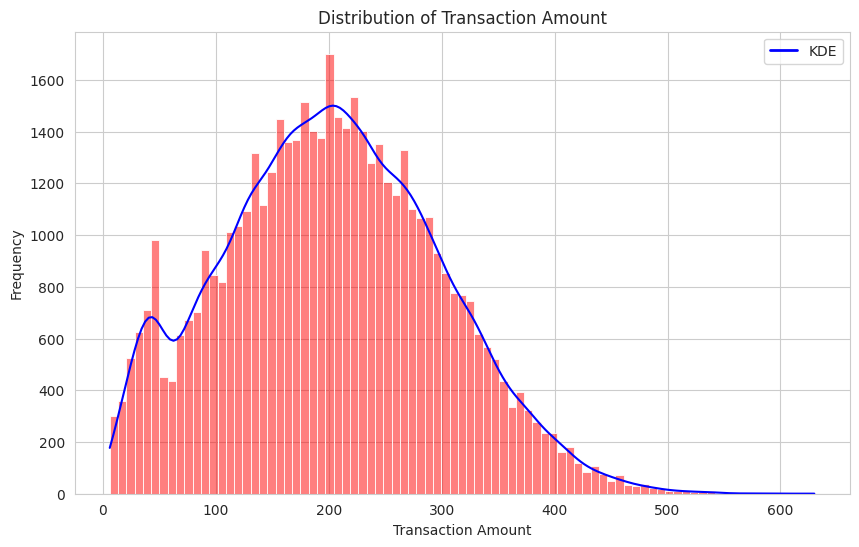

In [27]:
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
sns.histplot(df['amount'], kde=True, color='red')  # Change the color of the histogram
kde_line = mlines.Line2D([], [], color='blue', linewidth=2, label='KDE')
plt.legend(handles=[kde_line])
plt.title('Distribution of Transaction Amount')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.gca().get_lines()[-1].set_color('blue')  # Change the color of the KDE line
plt.show()

In [28]:
def plot_distribution(column, title, xlabel, ylabel):
    sns.set_style("whitegrid")

    # Print summary statistics for the column
    print(f"\nSummary statistics for '{column}' column:")
    print(df[column].value_counts())
    print("\n")

    # Create a countplot for the column with hue and legend parameters
    ax = sns.countplot(x=column, hue=column, data=df, palette='Reds', legend=False)

    # Create a grid
    plt.grid(True)

    # Set plot title and axis labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # Add count labels to the bars
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2.,
                height + 3,
                '{:1.0f}'.format(height),
                ha="center")

    # Show the plot distribution
    plt.show()



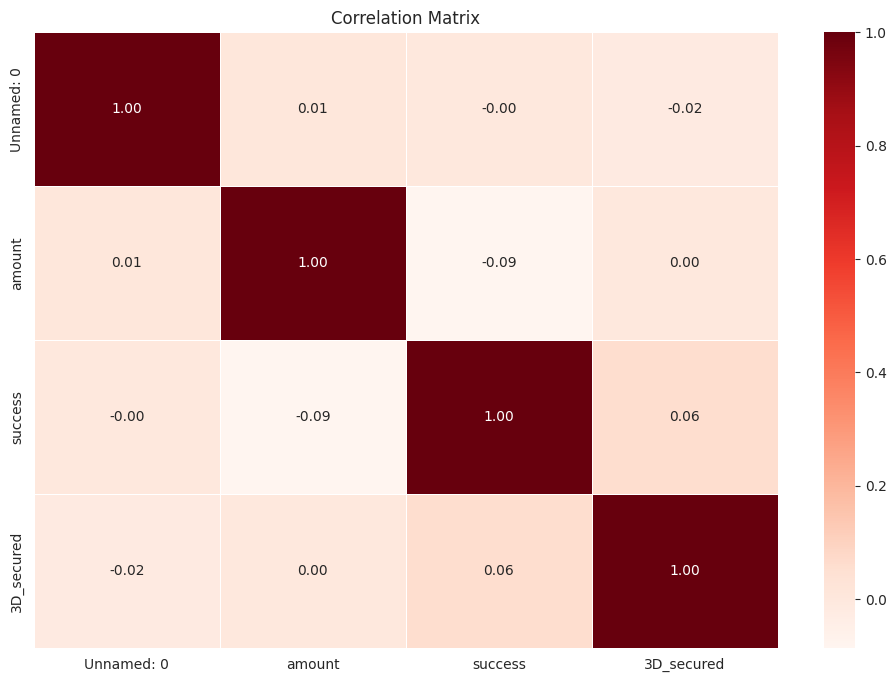

In [29]:
# Identify non-numeric columns
non_numeric_columns = df.select_dtypes(exclude='number').columns

# Drop non-numeric columns before calculating correlation
correlation_matrix = df.drop(columns=non_numeric_columns).corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Reds', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()


In [30]:

def process_transaction_fees(df):
    # Reset the index of the DataFrame
    df.reset_index(inplace=True)

    # Define dictionaries for mapping success and failure transaction fees based on card type
    success_fee_mapping = {
        'Moneycard': 5,
        'Goldcard': 10,
        'UK_Card': 3,
        'Simplecard': 1
    }
    failed_fee_mapping = {
        'Moneycard': 2,
        'Goldcard': 5,
        'UK_Card': 1,
        'Simplecard': 0.5
    }

    # Create a new column 'transaction_fee' based on success or failure, using np.where
    df['transaction_fee'] = np.where(df['success'] == 1, df['PSP'].map(success_fee_mapping),
                                      df['PSP'].map(failed_fee_mapping))

    # Print the first few rows of the updated DataFrame
    print("Associated the service fees of Payment Service Providers (PSPs) with the dataset under the column identifier 'transaction_fee' \n")
    print(df.head())

# Call the function with your DataFrame
process_transaction_fees(df)


Associated the service fees of Payment Service Providers (PSPs) with the dataset under the column identifier 'transaction_fee' 

   index  Unnamed: 0                tmsp  country  amount  success  \
0      0           0 2019-01-01 00:01:11  Germany      89        0   
1      1           1 2019-01-01 00:01:17  Germany      89        1   
2      2           2 2019-01-01 00:02:49  Germany     238        0   
3      3           3 2019-01-01 00:03:13  Germany     238        1   
4      4           4 2019-01-01 00:04:33  Austria     124        0   

          PSP  3D_secured    card  transaction_fee  
0     UK_Card           0    Visa              1.0  
1     UK_Card           0    Visa              3.0  
2     UK_Card           1  Diners              1.0  
3     UK_Card           1  Diners              3.0  
4  Simplecard           0  Diners              0.5  


In [31]:
# Convert 'tmsp' column to datetime format
df['tmsp'] = pd.to_datetime(df['tmsp'])
# Add 'day_of_week' column with numerical mapping (Monday 0, ..., Sunday 6)
df['day_of_week'] = df['tmsp'].dt.dayofweek
# Add 'minute_of_day' column
df['minute_of_day'] = df['tmsp'].dt.hour * 60 + df['tmsp'].dt.minute
# Print the first few rows of the updated DataFrame
print(df.head())

   index  Unnamed: 0                tmsp  country  amount  success  \
0      0           0 2019-01-01 00:01:11  Germany      89        0   
1      1           1 2019-01-01 00:01:17  Germany      89        1   
2      2           2 2019-01-01 00:02:49  Germany     238        0   
3      3           3 2019-01-01 00:03:13  Germany     238        1   
4      4           4 2019-01-01 00:04:33  Austria     124        0   

          PSP  3D_secured    card  transaction_fee  day_of_week  minute_of_day  
0     UK_Card           0    Visa              1.0            1              1  
1     UK_Card           0    Visa              3.0            1              1  
2     UK_Card           1  Diners              1.0            1              2  
3     UK_Card           1  Diners              3.0            1              3  
4  Simplecard           0  Diners              0.5            1              4  


In [32]:
# Sort the DataFrame by 'country', 'amount', 'day_of_week', 'minute_of_day'
df.sort_values(by=['country', 'amount', 'minute_of_day'], inplace=True)
# Create a new column 'payment_attempts' and initialize it with 1
df['payment_attempts'] = 1
# Identify rows where consecutive attempts have the same 'country', 'amount', 'day_of_week',and 'minute_of_day'
# Increment the 'payment_attempts' for those rows
df['payment_attempts'] = df.groupby(['country', 'amount', 'minute_of_day']).cumcount() + 1
# Reset the DataFrame index
df.reset_index(drop=True, inplace=True)
# Display the updated DataFrame
print("Dataset Post Data Transformation \n")

print(df.head())

Dataset Post Data Transformation 

   index  Unnamed: 0                tmsp  country  amount  success  \
0   9238        9238 2019-01-10 03:49:12  Austria       6        0   
1   9239        9239 2019-01-10 03:49:37  Austria       6        0   
2  33737       33737 2019-02-08 05:02:33  Austria       6        0   
3  33738       33738 2019-02-08 05:02:37  Austria       6        0   
4  33739       33739 2019-02-08 05:02:39  Austria       6        0   

          PSP  3D_secured    card  transaction_fee  day_of_week  \
0   Moneycard           0  Diners              2.0            3   
1  Simplecard           0  Diners              0.5            3   
2     UK_Card           0  Diners              1.0            4   
3     UK_Card           0  Diners              1.0            4   
4  Simplecard           0  Diners              0.5            4   

   minute_of_day  payment_attempts  
0            229                 1  
1            229                 2  
2            302              

In [33]:

# Drop the 'tmsp' column
df.drop('tmsp', axis=1, inplace=True)
print("Updated dataset after feature selection")
print(df.head())

Updated dataset after feature selection
   index  Unnamed: 0  country  amount  success         PSP  3D_secured  \
0   9238        9238  Austria       6        0   Moneycard           0   
1   9239        9239  Austria       6        0  Simplecard           0   
2  33737       33737  Austria       6        0     UK_Card           0   
3  33738       33738  Austria       6        0     UK_Card           0   
4  33739       33739  Austria       6        0  Simplecard           0   

     card  transaction_fee  day_of_week  minute_of_day  payment_attempts  
0  Diners              2.0            3            229                 1  
1  Diners              0.5            3            229                 2  
2  Diners              1.0            4            302                 1  
3  Diners              1.0            4            302                 2  
4  Diners              0.5            4            302                 3  



                    count      mean       std  min  25%  50%  75%   max
transaction_fee  50410.0  1.756477  1.814051  0.5  1.0  1.0  2.0  10.0 



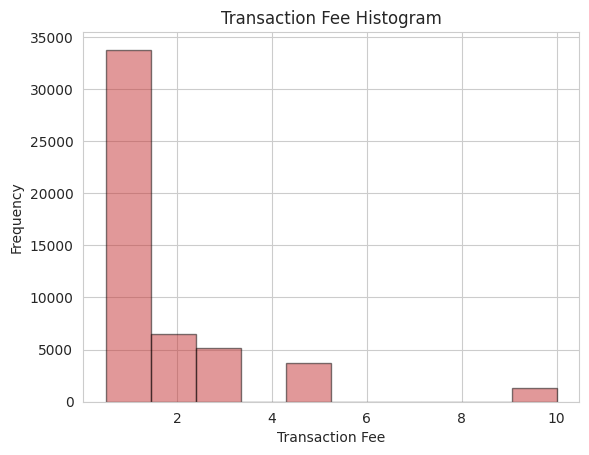

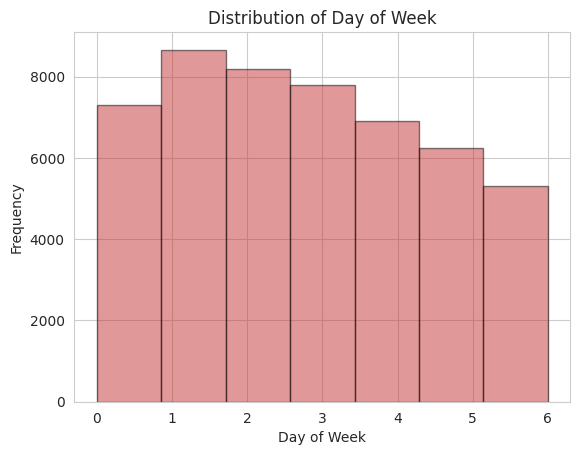

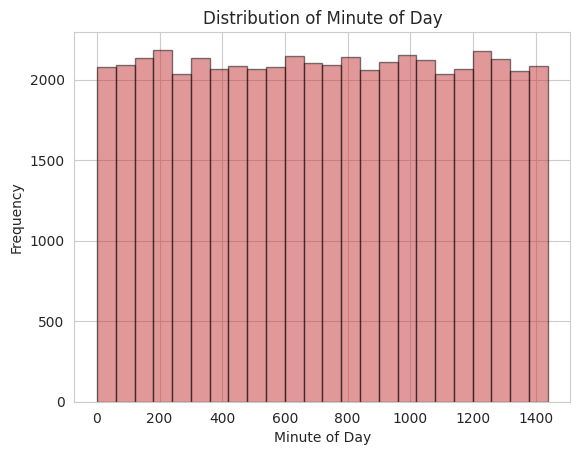

payment_attempts
1    37227
2    10463
3     2228
4      412
5       67
6       10
7        3
Name: count, dtype: int64


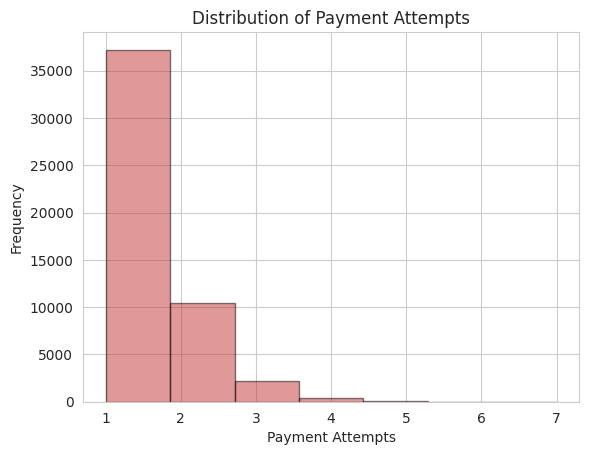

In [34]:

def visualize_data(df):
    # Select numeric columns for summary statistics
    numeric_columns = ['transaction_fee']

    # Calculate descriptive statistics for numeric columns
    numeric_summary = df[numeric_columns].describe()

    # Transpose the summary for better readability
    transposed_summary = numeric_summary.transpose()

    # Print the transposed summary
    print("\n", transposed_summary, "\n")

    # Create a histogram to visualize the distribution of transaction fees
    plt.hist(df['transaction_fee'], bins=10, edgecolor='black', color=sns.color_palette("coolwarm_r", 20)[0],
             alpha=0.5)

    # Set plot title, x-axis label, y-axis label
    plt.title('Transaction Fee Histogram')
    plt.xlabel('Transaction Fee')
    plt.ylabel('Frequency')

    # Show the plot
    plt.show()

    # Create a histogram to visualize the distribution of 'day_of_week'
    plt.hist(df['day_of_week'], bins=7, edgecolor='black', color=sns.color_palette("coolwarm_r", 20)[0], alpha=0.5)

    # Set x-axis label, y-axis label, and plot title
    plt.xlabel('Day of Week')
    plt.ylabel('Frequency')
    plt.title('Distribution of Day of Week')

    # Show the plot
    plt.show()

    # Create a histogram to visualize the distribution of 'minute_of_day'
    plt.hist(df['minute_of_day'], bins=24, edgecolor='black', color=sns.color_palette("coolwarm_r", 20)[0],
             alpha=0.5)

    # Set x-axis label, y-axis label, and plot title
    plt.xlabel('Minute of Day')
    plt.ylabel('Frequency')
    plt.title('Distribution of Minute of Day')

    # Show the plot
    plt.show()

    # Count the occurrences of each value in the 'payment_attempts' column and sort by index
    attempt_counts = df['payment_attempts'].value_counts().sort_index()

    # Print the count of payment attempts for each value
    print(attempt_counts)

    # Create a histogram to visualize the distribution of 'payment_attempts'
    plt.hist(df['payment_attempts'], bins=7, edgecolor='black', color=sns.color_palette("coolwarm_r", 20)[0],
             alpha=0.5)

    # Set x-axis label, y-axis label, and plot title
    plt.xlabel('Payment Attempts')
    plt.ylabel('Frequency')
    plt.title('Distribution of Payment Attempts')

    # Show the plot
    plt.show()

# Call the function with your DataFrame
visualize_data(df)


In [35]:
#Developing Model 
# Create a copy of the DataFrame
df_1 = df.copy()
# Drop the 'transaction_fee' column from the copied DataFrame
#df_1 = df_1.drop(['PSP'], axis=1)
df_1 = df_1.drop('transaction_fee', axis=1)
# Print the modified DataFrame without the 'transaction_fee' column
print(df_1) 
df_encoded_1 = pd.get_dummies(df_1, columns=['country', 'card'])

       index  Unnamed: 0      country  amount  success         PSP  \
0       9238        9238      Austria       6        0   Moneycard   
1       9239        9239      Austria       6        0  Simplecard   
2      33737       33737      Austria       6        0     UK_Card   
3      33738       33738      Austria       6        0     UK_Card   
4      33739       33739      Austria       6        0  Simplecard   
...      ...         ...          ...     ...      ...         ...   
50405   2619        2619  Switzerland     499        0     UK_Card   
50406   2620        2620  Switzerland     499        0     UK_Card   
50407   2621        2621  Switzerland     499        0     UK_Card   
50408   2622        2622  Switzerland     499        0     UK_Card   
50409   2623        2623  Switzerland     499        0     UK_Card   

       3D_secured    card  day_of_week  minute_of_day  payment_attempts  
0               0  Diners            3            229                 1  
1          

In [36]:

def evaluate_model(model, X_scaled, y, set_name):
    """
    Evaluate the performance of a model on a given dataset.
    
    Parameters:
    model (object): A trained model object.
    X_scaled (array): The scaled features of the dataset.
    y (array): The target variable of the dataset.
    set_name (str): The name of the dataset (e.g., 'Training', 'Testing').
    
    Returns:
    None
    """
    
    # Make predictions using the model
    y_pred = model.predict(X_scaled)
    
    # Get the predicted probabilities for each class
    y_pred_proba = model.predict_proba(X_scaled)[:, 1]
    
    # Calculate the precision, recall, F1-score, and AUC-ROC
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred)
    
    # Calculate the accura
    accuracy = accuracy_score(y, y_pred)
    
    # Get the confusion matrix
    conf_matrix = confusion_matrix(y, y_pred)
    
    # Print the model performance metrics
    print(f'\n{"="*20} {type(model).__name__} {"="*20}\n')
    print(f'Model Performance on {set_name} set - {type(model).__name__}:')
    print('\n')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-Score: {f1:.4f}')
    print(f'AUC-ROC: {roc_auc:.4f}')
    print(f'\n{"="*20}{"="*20}\n')
    print(classification_report(y, y_pred))
    
     # Calculate and print confusion matrix
    cm = confusion_matrix(y, y_pred)
    cm_df1 = pd.DataFrame(cm, index=model.classes_, columns=model.classes_)
    print(f'\n{"="*20}{"="*20}\n')
    print("Confusion Matrix:")
    print(cm_df1)
    plt.figure()
    plt.imshow(cm_df1, cmap='Reds')
    plt.title(f'Confusion Matrix: {set_name} - {type(model).__name__}')
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tick_params(axis='both', which='major', labelsize=8)
    plt.tight_layout()
    plt.show()
    
    # Plot the ROC curve
    fpr, tpr, _ = roc_curve(y, y_pred)
    plt.figure(figsize=(7, 5))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='AUC = %0.4f' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

In [37]:

# Encode categorical variables using one-hot encoding
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


df_1_encoded = pd.get_dummies(df_1, columns=['country', 'PSP', 'card'])
# Split the dataset into train, validation, and test sets
#X_original = df_1_encoded.drop('success', axis=1)
X_original = df_1_encoded.drop('success', axis=1)
y_original = df_1_encoded['success']
X_train_original, X_temp_original, y_train_original, y_temp_original = train_test_split(X_original,y_original, test_size=0.2, random_state=42)
X_validation_original, X_test_original, y_validation_original, y_test_original =train_test_split(X_temp_original, y_temp_original, test_size=0.5, random_state=42)



In [38]:

# Create and train a baseline KNN model
baseline_DT_model=DecisionTreeClassifier(random_state=42)

baseline_DT_model.fit(X_train_original, y_train_original)


# Evaluate the model on the validation set
evaluate_model(baseline_DT_model, X_validation_original, y_validation_original, "validation set")
# Evaluate the model on the test set
evaluate_model(baseline_DT_model, X_test_original, y_test_original, "test set")



==================== DecisionTreeClassifier ====================

Model Performance on validation set set - DecisionTreeClassifier:


Accuracy: 0.7153
Precision: 0.2857
Recall: 0.2843
F1-Score: 0.2850
AUC-ROC: 0.5535


              precision    recall  f1-score   support

           0       0.82      0.82      0.82      4035
           1       0.29      0.28      0.29      1006

    accuracy                           0.72      5041
   macro avg       0.55      0.55      0.55      5041
weighted avg       0.71      0.72      0.72      5041



Confusion Matrix:
      0    1
0  3320  715
1   720  286


In [ ]:
# Importing library for handling imbalanced datasets
from imblearn.over_sampling import SMOTE  # Synthetic Minority Over-sampling Technique

# Encode categorical variables using one-hot encoding
df_1 = pd.get_dummies(df_1, columns=['country', 'PSP', 'card'])
# Print the DataFrame after one-hot encoding
print(df_1)

# Drop the target variable 'success' from the features
X = df_1.drop('success', axis=1)
# Initialize the StandardScaler
scaler = StandardScaler()
# Fit and transform the features using StandardScaler
X_scaled = scaler.fit_transform(X)
# Create a DataFrame with scaled features and include the 'success' column
df_1_scaled = pd.DataFrame(X_scaled, columns=X.columns)
df_1_scaled['success'] = df_1['success']
# Print the DataFrame with scaled features
print(df_1_scaled)
#Extract features and target variable for SMOTE
X_smote = df_1_scaled.drop('success', axis=1)
y_smote = df_1_scaled['success']
# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_smote, y_smote)
# Create a new DataFrame with the resampled features and the target variable
df_1_resampled = pd.DataFrame(X_resampled, columns=X_smote.columns)
df_1_resampled['success'] = y_resampled
# Display the updated DataFrame with SMOTE
print(df_1_resampled)
# Development of Model A
# Split the resampled dataset into features (X_1) and target variable (y_1)
X_1 = df_1_resampled.drop('success', axis=1)
y_1 = df_1_resampled['success']
# Split the dataset into train, validation, and test sets
X_train_1, X_temp, y_train_1, y_temp = train_test_split(X_1, y_1, test_size=0.2, random_state=42)
X_valid_1, X_test_1, y_valid_1, y_test_1 = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
# Initialize a StandardScaler and scale the features for training, validation, and test sets
scaler = StandardScaler()
X_train_scaled_1 = scaler.fit_transform(X_train_1)
X_valid_scaled_1 = scaler.transform(X_valid_1)
X_test_scaled_1 = scaler.transform(X_test_1)

       index  Unnamed: 0  amount  success  3D_secured  day_of_week  \
0       9238        9238       6        0           0            3   
1       9239        9239       6        0           0            3   
2      33737       33737       6        0           0            4   
3      33738       33738       6        0           0            4   
4      33739       33739       6        0           0            4   
...      ...         ...     ...      ...         ...          ...   
50405   2619        2619     499        0           0            3   
50406   2620        2620     499        0           0            3   
50407   2621        2621     499        0           0            3   
50408   2622        2622     499        0           0            3   
50409   2623        2623     499        0           0            3   

       minute_of_day  payment_attempts  country_Austria  country_Germany  \
0                229                 1             True            False   
1      

In [ ]:
def calculate_classification_metrics(y_true, y_pred, y_pred_proba):
    """
    Calculate various classification metrics and display results.

    Parameters:
    y_true (array): True labels.
    y_pred (array): Predicted labels.
    y_pred_proba (array): Predicted probabilities for positive class.

    Returns:
    dict: Dictionary containing calculated metrics.
    """
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    accuracy = accuracy_score(y_true, y_pred)

    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': roc_auc
    }

    print("Classification Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    

    return metrics

In [ ]:
def evaluate_model(model, X_scaled, y, set_name):
    """
    Evaluate the performance of a model on a given dataset.

    Parameters:
    model (object): A trained model object.
    X_scaled (array): The scaled features of the dataset.
    y (array): The target variable of the dataset.
    set_name (str): The name of the dataset (e.g., 'Training', 'Testing').

    Returns:
    None
    """
    print(f'Model Performance on {set_name} set - {type(model).__name__}:')
    print("\n")
    y_pred = model.predict(X_scaled)
    y_pred_proba = model.predict_proba(X_scaled)[:, 1]
    calculate_classification_metrics(y, y_pred, y_pred_proba)
    conf_matrix = confusion_matrix(y, y_pred)
    cm_df = pd.DataFrame(conf_matrix, index=model.classes_, columns=model.classes_)

    print(f'\n{"="*20}{"="*20}\n')
    print(f'Classification Report: {set_name} set - {type(model).__name__}  \n')
    print(classification_report(y, y_pred))
    print(f'\n{"="*20}{"="*20}\n')
    print(f"Confusion Matrix: {set_name} set - {type(model).__name__} ")
    print(cm_df)
    print(f'\n{"="*20}{"="*20}\n')
    plt.figure()
    plt.imshow(cm_df, cmap='Reds')
    plt.title(f'Confusion Matrix: {set_name} set - {type(model).__name__}')
    plt.colorbar()
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tick_params(axis='both', which='major', labelsize=8)
    plt.tight_layout()
    plt.show()

    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    plt.figure(figsize=(7, 5))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y, y_pred_proba):.4f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC)Curve - {set_name} set')
    plt.legend(loc="lower right")
    plt.show()


In [ ]:
# Model Training and Evaluation
def train_and_evaluate_model(model, X_train_scaled, y_train, X_valid_scaled, y_valid, X_test_scaled, y_test):
    model.fit(X_train_scaled, y_train)

    print(f'\n{"="*20} {type(model).__name__} {"="*20}\n')

    print("Validation Set Evaluation:")
    evaluate_model(model, X_valid_scaled, y_valid, "Validation")

    print("Test Set Evaluation:")
    evaluate_model(model, X_test_scaled, y_test, "Test")


==================== DecisionTreeClassifier ====================

Validation Set Evaluation:
Model Performance on Validation set - DecisionTreeClassifier:


Classification Metrics:
Accuracy: 0.7759
Precision: 0.7782
Recall: 0.7675
F1-Score: 0.7728
AUC-ROC: 0.7758


Classification Report: Validation set - DecisionTreeClassifier  

              precision    recall  f1-score   support

           0       0.77      0.78      0.78      4045
           1       0.78      0.77      0.77      3991

    accuracy                           0.78      8036
   macro avg       0.78      0.78      0.78      8036
weighted avg       0.78      0.78      0.78      8036



Confusion Matrix: Validation set - DecisionTreeClassifier 
      0     1
0  3172   873
1   928  3063




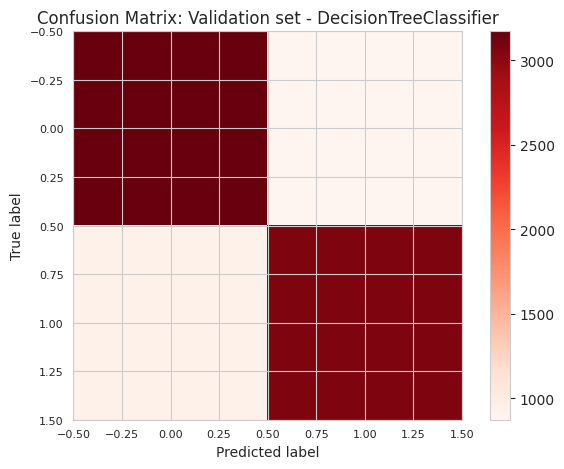

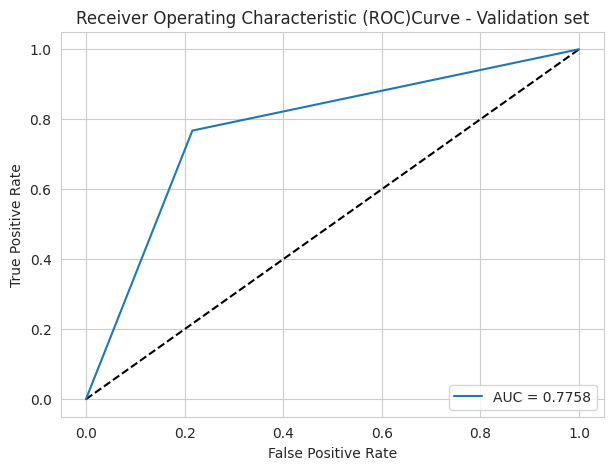

Test Set Evaluation:
Model Performance on Test set - DecisionTreeClassifier:


Classification Metrics:
Accuracy: 0.7842
Precision: 0.7920
Recall: 0.7703
F1-Score: 0.7810
AUC-ROC: 0.7842


Classification Report: Test set - DecisionTreeClassifier  

              precision    recall  f1-score   support

           0       0.78      0.80      0.79      4023
           1       0.79      0.77      0.78      4014

    accuracy                           0.78      8037
   macro avg       0.78      0.78      0.78      8037
weighted avg       0.78      0.78      0.78      8037



Confusion Matrix: Test set - DecisionTreeClassifier 
      0     1
0  3211   812
1   922  3092




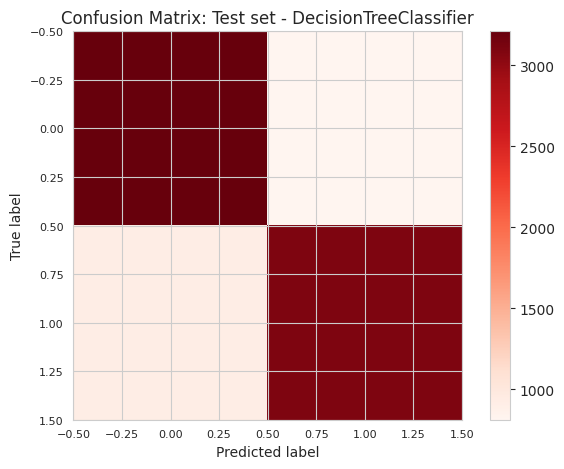

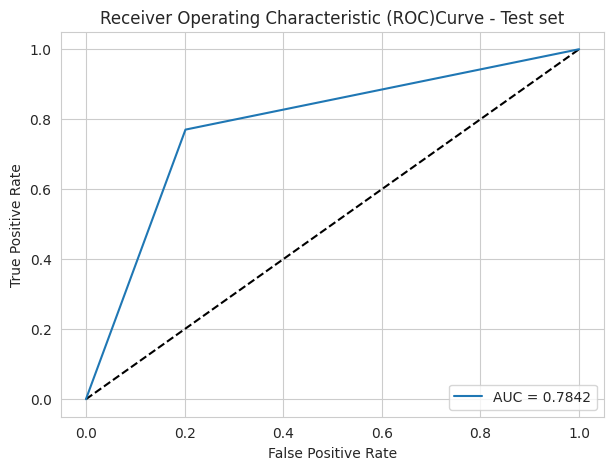

In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression


DT_model = DecisionTreeClassifier(random_state=42)
train_and_evaluate_model(DT_model, X_train_scaled_1, y_train_1, X_valid_scaled_1, y_valid_1, X_test_scaled_1, y_test_1)
